# QOSF Screening Tasks, Spring 2021
## Task 1: State approximation with parametric circuits

**Sashwat Anagolum**

This notebook is a solution for Task 1 of the QOSF Screening Tasks, Spring 2021. The task is outlined below:

The Swap test is a simple quantum circuit which, given two states, allows to compute how much do they differ from each other.

Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.
Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.
Suppose you are given with a random state, made by N qubits, for which you only know that it is a product state and each of the qubits are in the state | 0 > or | 1>. By product state we mean that it can be written as the product of single qubit states, without the need to do any summation. For example, the state
|a> = |01>
Is a product state, while the state
|b> = |00> + |11>
Is not.

Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.

#### Neccessary Imports

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

from qiskit import QuantumCircuit, execute, ClassicalRegister, IBMQ
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector, partial_trace, random_statevector, random_unitary
from qiskit.aqua.components.optimizers import SPSA, COBYLA, ADAM
from qiskit.compiler import transpile
from qiskit.circuit import Parameter, Gate
from qiskit.circuit.library import TwoLocal

### A 1 qubit universal circuit

I decided to start by searching for a universal 1 qubit circuit - from \[[1]\], we see that we can implement any 1-qubit state - even accounting for global phase -, using three gates - one $R_Z$, and $R_Y$, and another $R_Z$. If we start with a qubit in the $|0\rangle$ state, we end up with a state of the form

$$R_Z(\alpha)R_Y(\beta)R_Z(\gamma)|0\rangle = \begin{bmatrix} e^{i(\alpha - \gamma)} \cos \frac{\beta}{2} \\ e^{i(\alpha + \gamma)} \sin \frac{\beta}{2}\end{bmatrix}$$

In the case that we don't care about global phase (which is most cases!), we can actually use an even simpler circuit:

$$P(\gamma)R_Y(\theta)|0\rangle = \begin{bmatrix} \cos \theta \\ e^{i\gamma} \sin \theta\end{bmatrix}$$

Here $P$ represents the phase gate. Since we are only tasked with representing points on the Bloch sphere (which only shows relative phases) we don't need to account for global phase.

We also have the lazy version, using a single $U$ gate. This takes the $|0\rangle$ state to

$$U(\theta, \phi, \lambda)|0\rangle = \begin{bmatrix} \cos \theta \\ e^{i\phi} \sin \theta\end{bmatrix}$$

Here $\lambda$ does not matter, so we can set it to 0 - but it would if we applied the gate to a qubit that was not in the $|0\rangle$ state.

From this, though, a question arises - which of these is actually the cheapest to implement on real hardware? To figure this out, I transpiled example circuits to gate sets compatible with the publicly available IBMQ backends:

[1]: https://arxiv.org/abs/1804.03719

In [280]:
provider = IBMQ.load_account()
backends = provider.backends()[1:]
params = [Parameter('theta_' + str(i)) for i in range(3)]

qc = QuantumCircuit(1)
qc.rz(params[0], 0)
qc.ry(params[1], 0)
qc.rz(params[0], 0)
rotation_transpiled = [transpile(qc, backend=i) for i in backends]
rotation_depths = [circ.depth() for circ in rotation_transpiled]
rotation_ops = [circ.count_ops() for circ in rotation_transpiled]
rotation_mean_depth = sum(rotation_depths) / len(backends)

qc = QuantumCircuit(1)
qc.ry(params[0], 0)
qc.p(params[1], 0)
phase_transpiled = [transpile(qc, backend=i) for i in backends]
phase_depths = [circ.depth() for circ in phase_transpiled]
phase_ops = [circ.count_ops() for circ in phase_transpiled]
phase_mean_depth = sum(phase_depths) / len(backends)

qc = QuantumCircuit(1)
qc.u(params[0], params[1], params[2], 0)
u_transpiled = [transpile(qc, backend=i) for i in backends]
u_depths = [circ.depth() for circ in u_transpiled]
u_ops = [circ.count_ops() for circ in u_transpiled]
u_mean_depth = sum(phase_depths) / len(backends)

print('RZ + RY + RZ circuit (transpiled) mean depth: {}'.format(rotation_mean_depth))
print('RY + P circuit (transpiled) mean depth: {}'.format(phase_mean_depth))
print('U circuit (transpiled) mean depth: {}'.format(u_mean_depth))

RZ + RY + RZ circuit (transpiled) mean depth: 6.0
RY + P circuit (transpiled) mean depth: 5.0
U circuit (transpiled) mean depth: 5.0


We can also look at what operations need to be performed:

In [18]:
print('Operations used to implement RZ + RY + RZ circuit: {}'.format(rotation_ops[0]))
print('Operations used to implement RY + P circuit: {}'.format(phase_ops[0]))
print('Operations used to implement U circuit: {}'.format(u_ops[0]))

Operations used to implement RZ + RY + RZ circuit: OrderedDict([('rz', 4), ('sx', 2)])
Operations used to implement RY + P circuit: OrderedDict([('rz', 3), ('sx', 2)])
Operations used to implement U circuit: OrderedDict([('rz', 3), ('sx', 2)])


Looks like both the $R_Y + P$ and $U$ circuits use the same gates on real hardware - I would rather go with the $R_Y + P$ variant simply because the $U$ option has one parameter - $\lambda$ - which is, in this particular scenario (taking qubits from $|0\rangle$ to any 1 qubit state), redundant.

Let's build a function that allows us to implement this circuit:

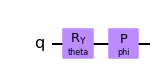

In [2]:
def construct_product_state_circuit(qc, params):
    """
    Construct product state circuit: constructs an n-qubit product state using n 1-qubit universal circuits.
    """
    for i in range(len(params) // 2):
        qc.ry(params[2 * i], i)
        qc.p(params[2 * i + 1], i)


qc = QuantumCircuit(1)
construct_product_state_circuit(qc, [Parameter('theta'), Parameter('phi')])
qc.draw(output='mpl')

While we know that this circuit can generate any 1-qubit state, visualizing this won't hurt:

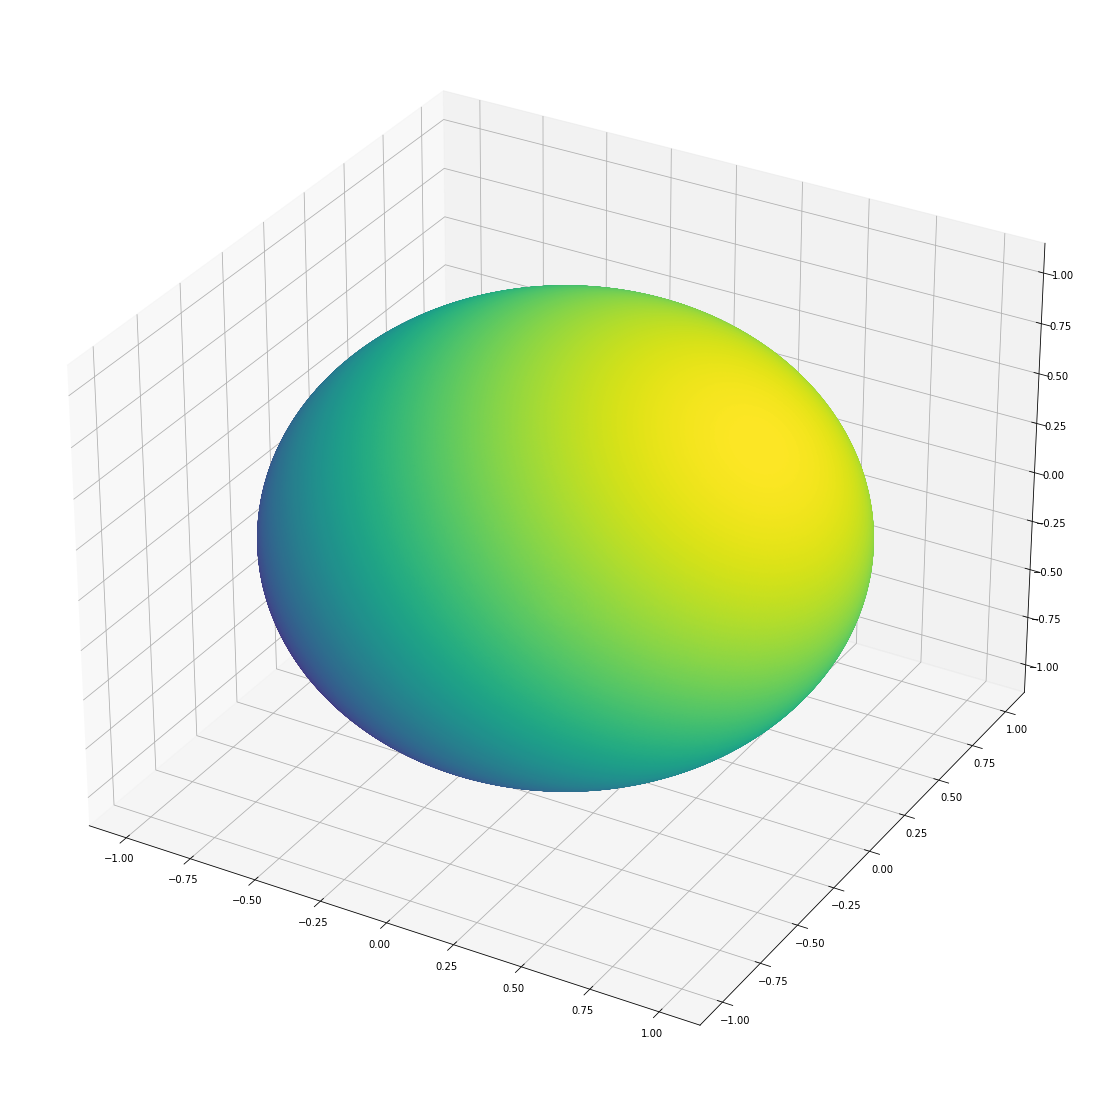

In [215]:
num_points = 999999

thetas = np.random.uniform(0, np.pi, num_points)
phis = np.random.uniform(0, 2 * np.pi, num_points)

vect_thetas = []
vect_phis = []

fig = plt.figure(figsize=[20, 20])

for i, theta in enumerate(thetas):
    qc = QuantumCircuit(1)
    construct_product_state_circuit(qc, [theta, phis[i]])
    vect = Statevector.from_instruction(qc).data
    vect_theta = np.arccos(vect[0])
    vect_phi = np.arcsin(vect[1].imag)
    vect_thetas.append(vect_theta)
    vect_phis.append(vect_phi)    

zs = np.cos(thetas)
radii = np.sqrt(1 - zs ** 2)
xs = np.cos(phis) * radii
ys = np.sin(phis) * radii

ax = fig.add_subplot(111, projection='3d')
    
ax.scatter(xs, ys, zs, c=xs +zs)
plt.show()

From the (super cool!) diagram above, can see that the points on the Bloch sphere that correspond to the random state generated using the circuit cover pretty much the entire sphere - another point of note is that the density of points closer to the poles is far higher than it is near the equator - this is because of the nonlinearities introduced by the definitions of the gates used in the circuit.

### The SWAP test

We can build a function that appends the gates we need for the SWAP test to any circuit we pass into it:

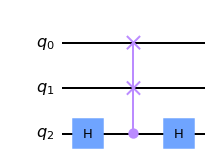

In [3]:
def append_cswap(qc, qubit_1, qubit_2, anc):
    """
    Append CSWAP: appends a CSWAP block to the circuit passed in. The qubits the gates are applied to are qubit_1 and qubit_2.
    The control qubit is passed into anc.
    """
    qc.h(anc)
    qc.cswap(anc, qubit_1, qubit_2)
    qc.h(anc)


qc = QuantumCircuit(3)
append_cswap(qc, 0, 1, 2)
qc.draw(output="mpl")

Let's also write some functions that can perform measurements on our circuit, and compute the overlap between two states:

In [10]:
def get_result(qc, noise_model=None, indexes=None, shots=1024):
    """
    Get result: get measurements from the quantum circuit passed in. It is possible to specify indexes indexes to
    measure - the default behaviour is to measure every qubit.
    """
    if not qc.num_clbits:
        creg = ClassicalRegister(len(indexes)) 
        qc.add_register(creg)

    if indexes:
        for i, index in enumerate(indexes):
            qc.measure(index, i)
    else:
        qc.measure_all()

    job = execute(qc, backend=QasmSimulator(noise_model=noise_model), shots=shots)
    result = job.result().get_counts()

    return result


def compute_state_overlap(qc, anc, noise_model=None):
    """
    Compute state overlap: computes the overlap between two 1-qubit states - the state preparation and CSWAP gates need to
    be applied prior to calling this function.
    """
    counts = get_result(qc, noise_model, [anc])
    if '0' not in counts.keys():
        return -1
    
    overlap = ((counts['0'] / 1024) - 0.5) * 2
    return overlap


qc= QuantumCircuit(3)
construct_product_state_circuit(qc, [np.pi / 2, np.pi / 2, np.pi / 2, -np.pi / 2])
append_cswap(qc, 0, 1, 2)

print('This overlap computed between orthogonal states should be 0. The measured overlap is: {}'.format(
    compute_state_overlap(qc, 2, None)))

This overlap computed between orthogonal states should be 0. The measured overlap is: 0.001953125


### Approximating 1 qubit states

Now that we've gotten the SWAP test and 1 qubit circuits working, its time to dive in - let's see if we can approximate any given 1 qubit state.

First, we construct a couple more functions:

In [65]:
def compute_product_state_loss(target_params, params, values_list, noise_model=None):
    """
    Compute product state loss: computes the loss for an n-qubit product state using the SWAP test.
    """
    qc = QuantumCircuit(2 * len(target_params) // 2 + 1)
    all_params = list(target_params) + list(params)
    construct_product_state_circuit(qc, all_params)
    overlaps = []
    state_size = qc.num_qubits // 2
    anc_index = qc.num_qubits - 1
    for i in range(state_size):
        append_cswap(qc, i, state_size + i, anc_index)
        overlaps.append(compute_state_overlap(qc, anc_index, noise_model))
        qc.reset(anc_index)

    function_value = -sum(overlaps) / len(overlaps)
    values_list.append(function_value)

    return function_value

def learn_product_state_circuit(target_params, init_params, optimizer, objective_function, noise_model=None):
    """
    Learn product state circuit: optimizes the parameters of an n-qubit product state circuit to approximate
    another n-qubit product state described by parameters target_params.
    """
    values_list = []
    result = optimizer.optimize(len(init_params), lambda x: objective_function(target_params, x, values_list, noise_model), 
                                initial_point=init_params)
    result = list(result)
    result.append(values_list)

    return result

In [224]:
target_params = np.pi * np.random.rand(2)
init_params = np.pi * np.random.rand(2)
result = learn_product_state_circuit(target_params, init_params, SPSA(maxiter=50), compute_product_state_loss)
print('Target and learned states overlap: {}'.format(-result[1]))

Target and learned states overlap: 1.0


Okay, great!
Now for a quick sanity check, just to make sure our functions are working as they should:

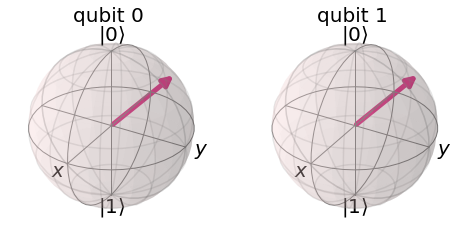

In [119]:
qc = QuantumCircuit(2)
construct_product_state_circuit(qc, np.append(target_params, result[0]))
plot_bloch_multivector(Statevector.from_instruction(qc))

Awesome!
Now we can extend this to multiple qubits. 

### Approximating n qubit product states
Here we're trying this out with 4 qubits:

In [114]:
target_params = np.pi * np.random.rand(8)
init_params = np.pi * np.random.rand(8)
result = learn_product_state_circuit(target_params, init_params, SPSA(maxiter=100), compute_product_state_loss)
print('Average qubit to qubit state overlap: {}'.format(-result[1]))

Average qubit to qubit state overlap: 0.998046875


Let's look at the Bloch vectors for the target state:

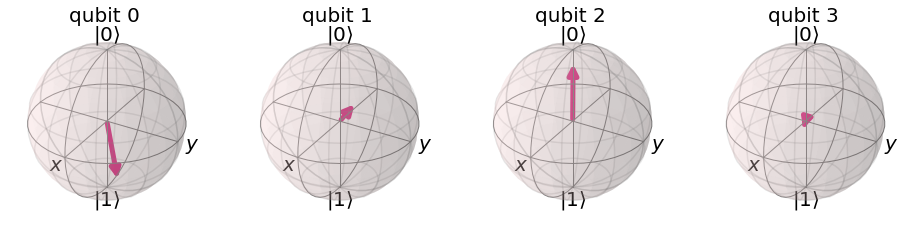

In [96]:
qc = QuantumCircuit(4)
construct_product_state_circuit(qc, target_params)
plot_bloch_multivector(Statevector.from_instruction(qc))

And now for the learned state:

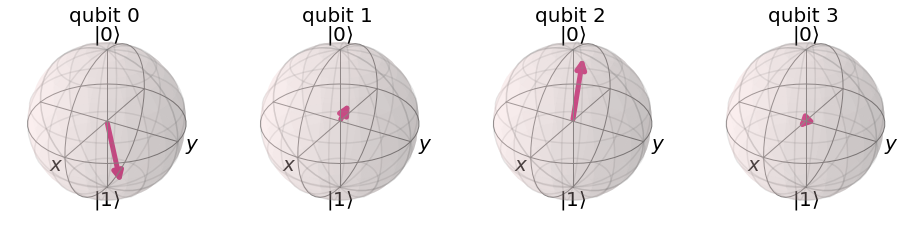

In [97]:
qc = QuantumCircuit(4)
construct_product_state_circuit(qc, result[0])
plot_bloch_multivector(Statevector.from_instruction(qc))

### Task Solution

The task asks us to learn a circuit for a product state that is equivalent to a classical bit string - i.e. every qubit is either in the $|0\rangle$ or the $|1\rangle$ state. Here we a function that helps us do just that:

In [234]:
def convert_bit_string_to_params(string):
    """
    Convert bit string to params: converts a given bit string to a parameter set meant to be used with the 1-qubit
    universal circuit.
    """
    params = []
    for i in string:
        rotation = 0
        if i == '1':
            rotation = np.pi

        params.append(rotation)
        params.append(0)
        
    return params

Now that we've got that out of the way, we can solve the task:

In [236]:
target_params = convert_bit_string_to_params('1011')
init_params = np.pi * np.random.rand(8)
result = learn_product_state_circuit(target_params, init_params, SPSA(maxiter=100), compute_product_state_loss)
print('Average qubit to qubit state overlap: {}'.format(-result[1]))

Average qubit to qubit state overlap: 1.0


We can also quickly check if the results are really right:

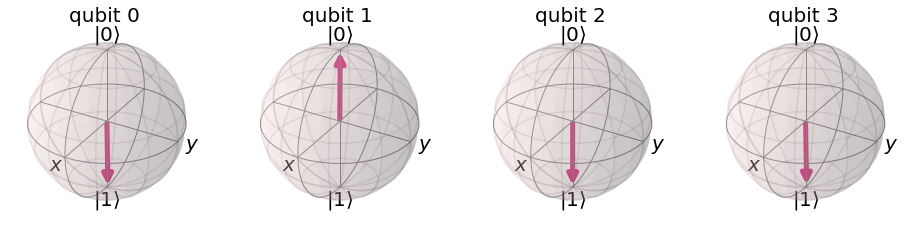

In [238]:
qc = QuantumCircuit(4)
construct_product_state_circuit(qc, result[0])
plot_bloch_multivector(Statevector.from_instruction(qc))

All right! Looks like things are working fine. Now we can focus on learning general product states - not just ones that are equivalent to bit strings.

#### Different sized product states

We can try to learn different sized product states, as shown here:

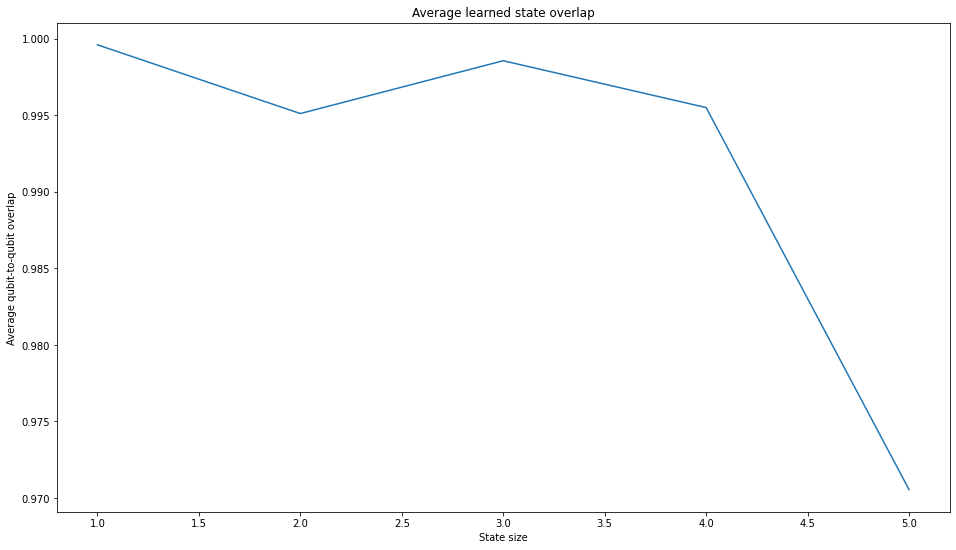

In [229]:
sizes = range(1, 6)
num_trials = 5
overlaps = []

for size in sizes:
    size_overlaps = []    
    for i in range(num_trials):
        target_params = np.pi * np.random.rand(2 * size)
        init_params = np.pi * np.random.rand(2 * size)
        result = learn_product_state_circuit(target_params, init_params, SPSA(maxiter=50), compute_product_state_loss)
        size_overlaps.append(result)
    overlaps.append(size_overlaps)

overlap_data_points = [-sum([j[1] for j in i]) / num_trials for i in overlaps]
                      
plt.figure(figsize=[16, 9])
plt.plot(range(1, 6), overlap_data_points)
plt.title('Average learned state overlap')
plt.xlabel('State size')
plt.ylabel('Average qubit-to-qubit overlap')
plt.show()

What we're seeing here is the average dot product of the target states and the state we learned - we can also see that there is a weak negative correlation between the number of qubits and the average dot product. 

This is unexpected, since trying to approximate a 5-qubit product state and five 1-qubit states are essentially the same thing. This can be attributed to the randomness of the parameters - the more states we try to learn, the more likely we are to be dealt a bad hand which can cannot optimize fully within the 50 iterations we run our optimizer for.

This also makes this problem very simple - all we're really doing is trying to learn many 1-qubit states, which really restricts us in the kind of analysis we can perform.

#### Using a different loss function

Here we can see how the loss function converges when we use the MSE (mean squared error) between the learned and target states as the objective function, as well as when we use the SWAP test. 

First we need to write a function that computes the MSE for us:

In [250]:
def compute_mse(target_state, qc, params, values_list, noise_model=None):
    """
    Compute MSE: computes the MSE between two 1-qubit states.
    """
    qc = QuantumCircuit(1)
    construct_product_state_circuit(qc, params)
    learned_state = Statevector.from_instruction(qc).data

    diff = target_state - learned_state
    mse = sum([abs(i) ** 2 for i in diff]) / len(diff)
    values_list.append(mse)

    return mse

Now we can run some tests:

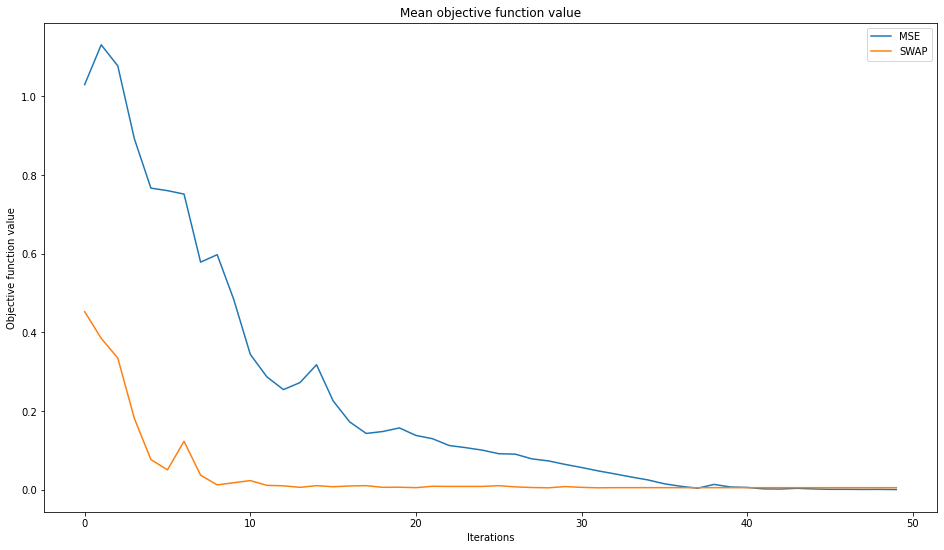

In [89]:
mse_results = []
swap_results = []

num_trials = 5
target_params = [2 * np.pi * np.random.rand(2) for i in range(num_trials)]
target_states = []

for i in target_params:
    qc = QuantumCircuit(1)
    construct_product_state_circuit(qc, i)
    statevector = Statevector.from_instruction(qc).data
    target_states.append(statevector)
    
for i in range(num_trials):
    init_params = 2 * np.pi * np.random.rand(2)
    swap_result = learn_product_state_circuit(target_params[i], init_params, COBYLA(maxiter=50), compute_product_state_loss)
    mse_result = learn_product_state_circuit(target_states[i], init_params, COBYLA(maxiter=50), compute_mse)

    swap_results.append(swap_result)
    mse_results.append(mse_result)

length = max([len(i[3]) for i in swap_results + mse_results])

for i in range(num_trials):
    swap_results[i][3] += [swap_results[i][3][-1] for j in range(len(swap_results[i][3]), length)]
    mse_results[i][3] += [mse_results[i][3][-1] for j in range(len(mse_results[i][3]), length)]    

swap_convergence = np.mean(np.concatenate([i[3] for i in swap_results]).reshape(num_trials, length).T, 1) + 1
mse_convergence = np.mean(np.concatenate([i[3] for i in mse_results]).reshape(num_trials, length).T, 1)
    
plt.figure(figsize=[16, 9])
plt.plot(mse_convergence)
plt.plot(swap_convergence)
plt.legend(['MSE', 'SWAP'])
plt.ylabel('Objective function value')
plt.xlabel('Iterations')
plt.title('Mean objective function value')
plt.show()

It looks like the objective function based on the SWAP test makes the optimizer converges a lot faster - on average, within 12 iterations, whereas the MSE objective function runs converge after about 35 iterations.

#### Learning product states: conclusions

Here we demonstrated how we can learn n-qubit product states - reducable to learning 1-qubit states. We also compared two different loss functions (MSE and one using the SWAP test), and found that using the SWAP test resulted in faster convergence. 

There we go - n-qubit product state approximation, done. Now for the fun part - time to go down the rabbit hole.

### Into the deep end: an n qubit universal circuit

My first thought on how to extend the problem was to try to approximate general $n$-qubit pure states, and start off by building a universal circuit for the same.

\[[1]\], \[[2]\] show methods to construct circuits that can generate general $n$-qubit states using Schmidt decomposition, which we go over super quickly here:

We can represent any $2n$-qubit state using this form:

$$|\psi\rangle = \sum_{i \in \{0, 1\}^{n}} \sum_{j \in \{0, 1\}^{n}} a_{ij} |ij\rangle$$

Using Schmidt decomposition, we construct a state of this form by choosing two orthonormal bases $\xi$ and $\rho$, and then writing $|\psi \rangle$ as

$$|\psi\rangle = \sum_{i = 0}^{2^n - 1} \lambda_i |\xi_i\rangle |\rho_i\rangle$$

for some $\lambda_i$'s. We represent these using an $n$-qubit state - prepared using an operator $B$, and the two bases with two unitary operators $U$ and $V$ that transform the computational basis we are currently working in into $\xi$ and $\rho$. The circuit would end up looking like this - here we use 4 qubits:

[1]: https://arxiv.org/abs/1804.03719
[2]: https://arxiv.org/abs/1003.5760

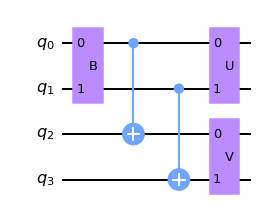

In [2]:
qc = QuantumCircuit(4)
U = Gate(name="U", num_qubits=2, params=[])
V = Gate(name="V", num_qubits=2, params=[])
B = Gate(name="B", num_qubits=2, params=[])

qc.append(B, [0, 1])
qc.cx(0, 2)
qc.cx(1, 3)
qc.append(U, [0, 1])
qc.append(V, [2, 3])
qc.draw(output='mpl')

What we're doing with the $CX$s is effectively copying over the initial state (the $\lambda_i$'s) over to the second set of $n$ qubits as well. So, in general, we'll need $n$ $CX$ gates, and 3 $n$-qubit unitaries, although, as we know, we can decompose these until we end up with sequences of rotation gates and $CX$s. 

We can quickly figure out what end state this circuit gives us:

$$(U \otimes V)\:(CX_{n}^{0}\:CX_{n + 1}^{1}\: \cdots \: CX_{2n - 1}^{n - 1})\:(B \otimes I)|000...0\rangle$$

$$ = (U \otimes V)\:(CX_{n}^{0}\:CX_{n + 1}^{1}\: \cdots \: CX_{2n - 1}^{n - 1}) \sum_{i = 0}^{2 ^ n - 1} b_{i,0} |e_i\rangle |e_0\rangle, \:\:\:e_i \in \{0, 1\}^{\otimes n}, b_{i,0} = B_{i,0}$$

$$ = (U \otimes V) \sum_{i = 0}^{2 ^ n - 1} b_{i,0} |e_i\rangle |e_i\rangle$$

$$ = \sum_{i = 0}^{2 ^ n - 1} b_{i,0} (U|e_i\rangle)(V|e_i\rangle)$$

This is the state we wanted to construct - now all we need to do is figure out the values for the unitaries we use:

Let $|\psi\rangle = \sum_{i, j = 0}^{2^n - 1} a_{i, j} |e_i\rangle|e_j\rangle$, and $A$ be a $2^n \times 2^n$ matrix such that $A_{i, j} = a_{i, j}$. Then:

$$\sum_{i, j = 0}^{2^n - 1} a_{i, j}|e_i\rangle |e_j\rangle = \sum_{k = 0}^{2^n - 1} b_{k, 0}(U|e_i\rangle)(V|e_i\rangle)$$

Multiplying by $\langle e_j| \langle e_i|$:

$$a_{i, j} = \sum_{k = 0}^{2^n - 1} b_{k, 0} u_{i, k} v_{j, k}, \:\:\: u_{i, k} = \langle e_i|U|e_k\rangle, v_{j, k} = \langle e_j|V|e_k\rangle$$

How do we get this? All the $|e_i\rangle$'s are orthonormal - so when we compute $\langle e_i|e_j\rangle, i \neq j$, we get 0, so the only term left is $\langle e_j | \langle e_i| a_{i, j} |e_i\rangle |e_j\rangle = a_{i, j}$.

From this, we know that

$$V diag(b_{0, 0}, b_{1, 0}, b_{2, 0} \cdots, b_{2^n - 1, 0})U^T = A$$

$$(V diag(b_{0, 0}, b_{1, 0}, b_{2, 0} \cdots, b_{2^n - 1, 0})U^T)^\dagger V diag(b_{0, 0}, b_{1, 0}, b_{2, 0} \cdots, b_{2^n - 1, 0})U^T = U^{T\dagger}diag(b_{0, 0}^2, b_{1, 0}^2, b_{2, 0}^2 \cdots, b_{2^n - 1, 0}^2)U^T = A^\dagger A$$

So the LHS is simply the eigendecomposition of $A^\dagger A$. To summarize:

<p style="text-align: center">$U$ and the $\lambda_i$s is obtained via the eigendecomposition of $A^T A$</p>

$$B_{i, 1} = \sqrt{\lambda_i}$$

$$V = AU^{T\dagger} diag(\sqrt{\lambda_0}, \sqrt{\lambda_1} \cdots \sqrt{\lambda_{2^n - 1}})^{-1}$$

In [2]:
params = [Parameter('theta_' + str(i)) for i in range(40)]
    
def single_qubit_universal_gate(qc, qubit, params):
    """
    Single qubit universal gate: appends a U gate to a given circuit.
    """
    qc.u(params[0], params[1], params[2], qubit)
    
def two_qubit_universal_gate(qc, qubit_1, qubit_2, params):
    """
    Two qubit universal gate: appends a two qubit universal gate made up of rotation gates, U gates and CX gates to 
    the circuit passed in. The order of the qubits passed in matters.
    """
    single_qubit_universal_gate(qc, qubit_1, params[:3])
    single_qubit_universal_gate(qc, qubit_1, params[3:6])
    qc.cx(qubit_2, qubit_1)
    qc.rz(params[6], qubit_1)
    qc.ry(params[7], qubit_2)
    qc.cx(qubit_1, qubit_2)
    qc.ry(params[8], qubit_2)
    qc.cx(qubit_2, qubit_1)
    single_qubit_universal_gate(qc, qubit_1, params[9:12])
    single_qubit_universal_gate(qc, qubit_1, params[12:])
    
def two_qubit_state_prep(qc, qubit_1, qubit_2, params):
    """
    Two qubit state preparation: appends a two qubit state preparation gate to the circuit passed in.
    """
    qc.ry(params[0], qubit_1)
    qc.p(params[1], qubit_1)
    qc.cx(qubit_1, qubit_2)
    single_qubit_universal_gate(qc, qubit_1, params[3:6])
    single_qubit_universal_gate(qc, qubit_2, params[6:9])
    
def four_qubit_state_prep(qc, qubits, params):
    """
    Four qubit state preparation: appends a four qubit state preparation gate to the circuit passed in.
    """
    two_qubit_state_prep(qc, qubits[0], qubits[1], params[:9])
    qc.barrier()
    qc.cx(qubits[0], qubits[2])
    qc.cx(qubits[1], qubits[3])
    qc.barrier()
    two_qubit_universal_gate(qc, qubits[0], qubits[1], params[9:24])
    two_qubit_universal_gate(qc, qubits[2], qubits[3], params[24:39])

This one is a universal two qubit circuit:

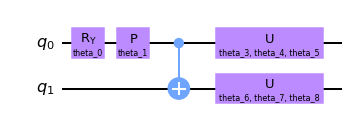

In [4]:
qc = QuantumCircuit(2)
two_qubit_state_prep(qc, 0, 1, params[:9])
qc.draw(output='mpl')

This one is a universal four qubit circuit:

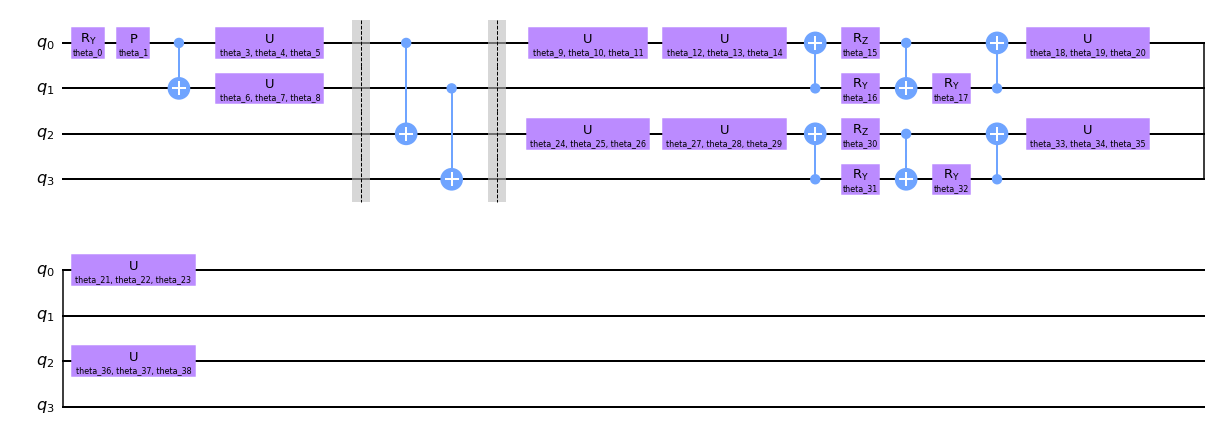

In [5]:
qc = QuantumCircuit(4)
four_qubit_state_prep(qc, range(4), params)
qc.draw(output='mpl')

The circuit above uses 18 1-qubit gates (17 if we replace the $R_Y + P$ in the beginning for a single $U$ gate, although these get decomposed to the same number of gates on real hardware), and 9 $CX$s - it also looks a lot less pretty than the one we saw above for four qubits with the opaque gates.

This is merely one option - there are numerous other approaches, such as the one outlined in \[[3]\], which uses uniformly controlled rotations - specifically, it uses $2^n - 1$ 1-qubit gates and $2^{n + 1} - 2n - 2 \:\:C_X$s to construct an n-qubit state.

### Common ans√§tze

In practice, however, we rarely see these circuits being used: most of the time we use much simpler, stackable layers of gates - common ones include stacking layers of $R_Y$ (or any other rotation) and $C_Z$ (or $C_X$) gates, the latter being used to create entanglement between qubits. 

These circuits form the basis for most quantum machine learning algorithms that we see in the NISQ era we are in today, like \[[4]\], \[[5]\], and others.

Why not just use the universal circuits? 

The cost of using these is super high - we can achieve results that are good enough for us using much simpler circuits like the ones we talked about above.

For example, take a 4-qubit circuit composed of alternating layers of $R_Y + R_X$ and $C_Z$ gates - it might look something like this:

[3]: https://arxiv.org/pdf/quant-ph/0407010.pdf
[4]: https://arxiv.org/abs/1802.06002
[5]: https://arxiv.org/abs/2006.06004

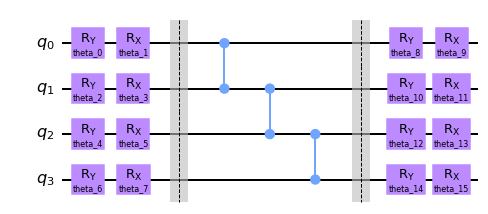

In [60]:
params = [Parameter('theta_' + str(i)) for i in range(16)]

qc = QuantumCircuit(4)
for i in range(4):
    qc.ry(params[2 * i], i)
    qc.rx(params[2 * i + 1], i)
    
qc.barrier()
    
for i in range(3):
    qc.cz(i, i + 1)
    
qc.barrier()
    
for i in range(4):
    qc.ry(params[8 + 2 * i], i)
    qc.rx(params[8 + 2 * i + 1], i)
    
qc.draw(output='mpl')

Suprisingly, this circuit can do a pretty good job of learning most states - with far less $C_X$s and rotation gates than a universal circuit.

The question arises, then: how well do these circuits perform? Are there certain kinds that are better?

### How good are common ans√§tze?

To explore this, we can look at a few quantities - precisely, the expressibility of a circuit, and its entangledness.

#### Expressibility

To quantify the expressibility of an ansatz, we look at how close the set of states generated by sampling uniformly from the ansatz parameter space is to a state t-design, as shown in \[[6]\]. A state t-design is called so if it satifies the equation below:

$$\int p(\alpha) f(|\psi(\alpha)\rangle) d\alpha = \int f(|\psi(\alpha)\rangle)$$

where both integrals are taken with respect to the Haar measure. $p(\alpha)$ represents the probability assciated with that set $\alpha$, $|\psi\rangle$ represents the quuantum state constructed using $\alpha$ as parameters, and $f$ a polynomial function of degree $t$ or less in both the elements of $|\psi\rangle$ and their complex conjugates.

We're not hoping to have our circuits be perfect t-designs, however - we're okay with them being close enough to one. We quanity this closeness using the description of an $\epsilon$-approximate t-design:

$$(1 - \epsilon)\int f(|\psi(\alpha)\rangle) \leq \int p(\alpha) f(|\psi(\alpha)\rangle) d\alpha \leq (1 + \epsilon)\int f(|\psi(\alpha)\rangle)$$

The value of $\epsilon$ gives us an idea of how well the set of states our circuit can generate approximates a state t-design.

We can compute the value of $\epsilon$ using this equation:

$$A =  \frac{1}{|U|} \sum_{u \in U} |\psi_u\rangle \langle \psi_u| - \frac{1}{|\Theta|}\sum_{\theta \in \Theta} |\psi_\theta\rangle \langle \psi_\theta|$$

To get $\epsilon$ from $A$, a $2^n \times 2^n$ matrix, we take the square of its Hilbert-Schmidt norm:

$$Tr[A^\dagger A]$$

These functions help us compute the expressibility of different ans√§tze:

[6]: https://arxiv.org/pdf/1905.10876.pdf

In [19]:
def generate_random_unitary(N):
    """
    Generate random unitary: generates a Haar-random unitary of dimensions N x N.
    """
    random_matrix = np.random.rand(N, N) + 1j * np.random.rand(N, N)
    q, r = np.linalg.qr(random_matrix, 'complete')
    normed_q = np.matmul(q, np.diag(np.diagonal(r) / np.abs(np.diagonal(r))))

    return normed_q


def approximate_haar_integral(num_qubits, num_states):
    """
    Approximate Haar integral: approximates an integral over Haar-randomly distributed states.
    """
    N = 2 ** num_qubits
    result = np.zeros((N, N), dtype='complex128')
    
    for i in range(num_states):
        unitary = generate_random_unitary(N)
        generated_state = unitary[:, 0]
        result += np.outer(generated_state, generated_state)
    
    return result / num_states


def approximate_ansatz_integral(qc, num_qubits, num_states, num_params):
    """
    Approximate ansatz integral: approximates an integral over parameter space of the chosen ansatz.
    """
    N = 2 ** num_qubits
    result = np.zeros((N, N), dtype='complex128')

    for i in range(num_states):
        params = np.random.uniform(-np.pi, np.pi, num_params)
        qc_fixed = qc.assign_parameters(params) if num_params else qc
        statevector = Statevector.from_instruction(qc_fixed).data
        result += np.outer(statevector, statevector)
        
    return result / num_states
        
        
def compute_expressibility(qc, num_qubits, num_states, num_params):
    """
    Compute expressibility: computes the expressibility of a given ansatz using the notion of an ùúñ-approximate state
    t-design and the Hilbert-Schmidt norm.
    """
    haar_matrix = approximate_haar_integral(num_qubits, num_states)
    ansatz_matrix = approximate_ansatz_integral(qc, num_qubits, num_states, num_params)
    result = haar_matrix - ansatz_matrix
    squared_hs_norm = np.trace(np.matmul(np.conj(result.T), result)).real
    
    return squared_hs_norm

#### Entangledness

\[[6]\] also outlines a method to quantify the entangledness of a state using the Meyer-Wallach measure $Q(|\psi\rangle)$ of a quantum state $|\psi\rangle$. \[[7]\] introduces an equivalent expression that highlights the measure's meaning as a quantification of a state's entangledness:

$$Q(|\psi\rangle) = 2 \left ( 1 - \frac{1}{n}\sum_{i = 0}^{n - 1} Tr \left [ \rho^2_i\right ]\right ) $$

Here $\rho^2_i$ refers to the density matrix for the $i$th qubit after tracing out all the other qubits, and $n$ the number of qubits. We can adapt this to our VQC setting by averaging over samples drawn uniformly from the parameter space, as shown here:

$$ Ent = \frac{2}{|\Theta|}  \sum_{\theta \in \Theta}\left ( 1 - \frac{1}{n}\sum_{i = 0}^{n - 1} Tr \left [ \rho^2_i(\theta)\right ]\right )  $$

Here $\Theta$ refers to the set of parameters uniformly sampled from the parameter space.


[6]: https://arxiv.org/pdf/1905.10876.pdf
[7]: https://arxiv.org/pdf/quant-ph/0305094.pdf

In [18]:
def compute_entangledness(qc, num_samples, num_qubits, num_params):
    """
    Compute entangledness: computes the entangledness of an ansatz using the Meyer-Wallach measure.
    """
    ents = []
    indices = list(range(num_qubits))

    for i in range(num_samples):
        params = np.random.uniform(-np.pi, np.pi, num_params)
        qc_fixed = qc.assign_parameters(params) if num_params else qc
        statevector = Statevector.from_instruction(qc_fixed).data
        traces = []
        
        for i in range(num_qubits):
            reduced_density_matrix = partial_trace(statevector, indices[:i] + indices[i + 1:]).data
            trace = np.trace(np.matmul(reduced_density_matrix, reduced_density_matrix))
            traces.append(trace)
            
        ents.append(1 - (sum(traces) / num_qubits))
    
    return 2 * sum(ents).real / num_samples

Now, let's run some circuits!

We can start by creating some common ans√§tze:

In [4]:
def two_local(num_qubits, num_layers, rotation_gate, entanglement_gate, entanglement_map=None, barriers=False):
    """
    Two Local: return a two local circuit with the parameters passed in.
    """
    return TwoLocal(num_qubits, rotation_gate, entanglement_gate, entanglement_map, num_layers, insert_barriers=barriers)

Here's $R_Y + C_Z$:

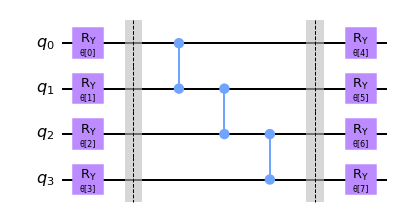

In [266]:
two_local(4, 1, 'ry', 'cz', 'linear', barriers=True).draw(output='mpl')

And here's another that uses $R_Y$ and $R_Z$ rotation gates, with $C_X$ gates for entanglement:

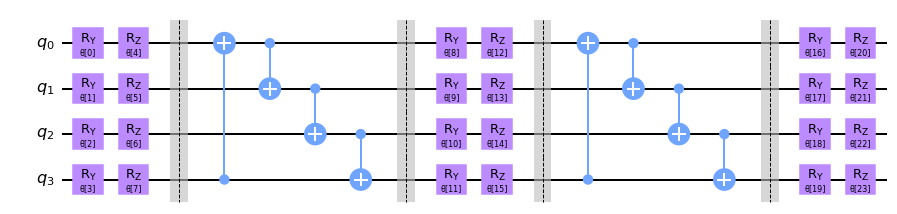

In [265]:
two_local(4, 2, ['ry', 'rz'], 'cx', 'circular', barriers=True).draw(output='mpl')

Now, let's figure out which ansatz is the most expressible and has the highest entanglement capacity:

#### Different gate selections

First, let's create a function that makes it easy for us to compute these metrics for different circuits:

In [71]:
def compute_metrics(ansatze, num_states):
    """
    Compute metrics: compute the expressibility and entangledness of the given ans√§tze.
    """
    metrics = []
    for ansatz in ansatze:
        ansatz_metrics = []
        ansatz_metrics.append(compute_expressibility(ansatz, ansatz.num_qubits, num_states, ansatz.num_parameters))
        ansatz_metrics.append(compute_entangledness(ansatz, num_states, ansatz.num_qubits, ansatz.num_parameters))
        metrics.append(ansatz_metrics)
        
    return metrics

Here we can look at how different ans√§tze stack up against each other - the GHZ and $|0\ldots0\rangle$ states are included for reference.

Note that we aren't plotting the expressibility measure exactly as we compute it - since a higher score is related to a lower expressibility, we can look at the multiplicative inverses of the computed scores to get a better idea of how expressive the different circuits are.

To make sure our baseline is 0, we also subtract the score we get for the zero circuit from every score we get.

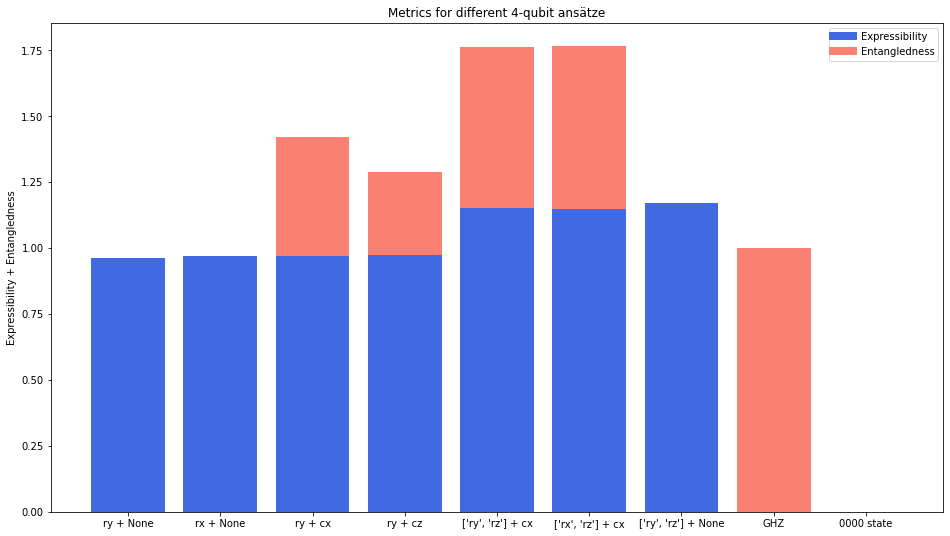

In [251]:
ansatz_gates = [['ry', None], ['rx', None], ['ry', 'cx'], ['ry', 'cz'], [['ry', 'rz'], 'cx'], 
                [['rx', 'rz'], 'cx'], [['ry', 'rz'], None]]
num_qubits = 4
num_layers = 1
circuits = []

for gates in ansatz_gates:
    ansatz = two_local(num_qubits, num_layers, gates[0], gates[1], 'linear')
    circuits.append(ansatz)
    
qc = QuantumCircuit(num_qubits)
qc.h(0)
for i in range(num_qubits - 1):
    qc.cx(i, i + 1)
    
circuits.append(qc)

qc = QuantumCircuit(num_qubits)
circuits.append(qc)

metrics = compute_metrics(circuits, 1000)
indices = range(len(metrics))

expressibility = [(1 / i[0]) - (1 / metrics[-1][0]) for i in metrics]
entangledness = [i[1] for i in metrics]
labels = [str(i[0]) + ' + ' + str(i[1]) for i in ansatz_gates] + ['GHZ', '0000 state']

plt.figure(figsize=[16, 9])
plt.bar(indices, expressibility, color='royalblue')
plt.bar(indices, entangledness, bottom=expressibility, color='salmon')
plt.xticks(indices, labels)
plt.ylabel('Expressibility + Entangledness')
plt.title('Metrics for different 4-qubit ans√§tze')

lines = [Line2D([0], [0], color='royalblue', lw=8, label='Expressibility'),
        Line2D([0], [0], color='salmon', lw=8, label='Entangledness')]
plt.legend(handles=lines)

plt.show()

We can see that the $R_Y$ and $R_X$ circuits have similar expressibility to the other ans√§tze, despite not having any entanglement gates - this is a drawback of the expressibility measure used, in that since it uses the statevector generated by a circuit, it does not take entanglement into account, which is why pairing it with a measure of entangledness is essential during any analysis.

It looks like circuits with two kinds of rotation gates have a better expressibility score - they can generate more kinds of statevectors, since that is what we are basing the expressibility score off of. If we could somehow account for entanglement there is no doubt that the $R_Y + R_Z$ circuit would perform poorly compared to one that contained entanglement gates.

From the chart, the $R_X + R_Z + C_X$ circuit is the best of the lot - however, our comparision might be slightly unfair; this circuit has 16 parameters (so do the $R_Y + R_Z$ and $R_Y + R_Z + C_X$ circuits), while the single rotation gate circuits use only 8. 

To equalize things, let's look at the stats for the same ans√§tze, but with the number of layers changed so that they all use 16 parameters:

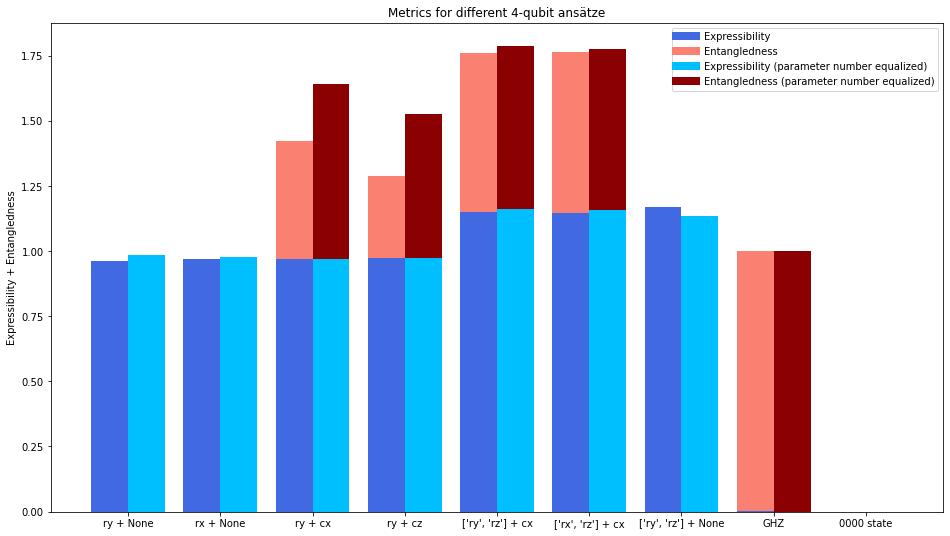

In [253]:
num_layers = [3 for i in range(7)]
num_layers[4] = 1
num_layers[5] = 1
num_layers[6] = 1
width = 0.4
new_indices = [i + width for i in indices]
new_circuits = []

for i, gates in enumerate(ansatz_gates):
    ansatz = two_local(num_qubits, num_layers[i], gates[0], gates[1], 'linear')
    new_circuits.append(ansatz)
    
new_circuits += circuits[-2:]

new_metrics = compute_metrics(new_circuits, 1000)

new_expressibility = [(1 / i[0]) - (1 / new_metrics[-1][0]) for i in new_metrics]
new_entangledness = [i[1] for i in new_metrics]

plt.figure(figsize=[16, 9])
plt.bar(indices, expressibility, width, color='royalblue')
plt.bar(indices, entangledness, width, bottom=expressibility, color='salmon')

plt.bar(new_indices, new_expressibility, width, color='deepskyblue')
plt.bar(new_indices, new_entangledness, width, bottom=new_expressibility, color='darkred')

plt.xticks([i + 0.2 for i in indices], labels)
plt.ylabel('Expressibility + Entangledness')
plt.title('Metrics for different 4-qubit ans√§tze')

lines = [Line2D([0], [0], color='royalblue', lw=8, label='Expressibility'),
        Line2D([0], [0], color='salmon', lw=8, label='Entangledness'),
        Line2D([0], [0], color='deepskyblue', lw=8, label='Expressibility (parameter number equalized)'),
        Line2D([0], [0], color='darkred', lw=8, label='Entangledness (parameter number equalized)')]
plt.legend(handles=lines)

plt.show()

It looks like even when we equate the number of parameters, the $R_X + R_Z + C_X$ and $R_Y + R_Z + C_X$ circuits perform better in terms of expressibility - they are beaten out by the $R_Y + C_Z$ circuit in entangledness. 

The entangledness of the $R_Y + C_X$ and $R_Y + C_Z$ circuits increasing is a result of the additional $C_X$ gates in the circuits - the entanglement map used is a linear one, which uses only $n - 1$ $C_X$ gates, so there would indeed be some scope for increased entangledness.

The expressibility staying the same is both good and bad news. The bad news first: this is another sign that our expressibility measure does not care about entanglement, as well as circuit depth - in other words, it simply provides a general descriptor of how expressive that family of circuits is (the circuits that use different number of layers of the same stackable blocks).

The good news: this means that, as long as we only care about approximating probability distributions, just 1 layer - and $2n$ parameters - is enough to approximate a $2^n$ dimensional PMF. 
Or, more accurately, we get the best results we can get from the $R_Y + C_X$ or $C_Z$ circuits with just one layer - performance is not likely to improve when we increase circuit depth.

The metrics staying the same for the no-entanglement circuits is not suprising - one rotation gate is just as good as two if the second is applied right after the first; you could just add up the angles.

We do see some small variations in the metrics for the circuits wit, even though the ansatz stayed the same - this is becuase our metrics depend on random parameter generation, and so will have some inherent variability. We can reduce this by increasing the number of states we use to compute the metrics.

However, the results open up a new avenue of exploration - since the entangledness improved  for the $R_Y + C_X$ and $R_Y + C_Z$ circuits when we added two more layers, what would happen if we increase circuit depth further?

Let's focus further investigation on the $R_Y + R_Z + C_Z$ circuit - we know that the $R_Y + C_X$ and $R_Y + C_Z$ circuits can't generate states with complex amplitudes, which we need to approximate general $n$-qubit states.

#### Different circuit depths

Here we run $R_Y + R_Z + CZ$ ans√§tze with different circuit depths. Let's first take a look at what a 

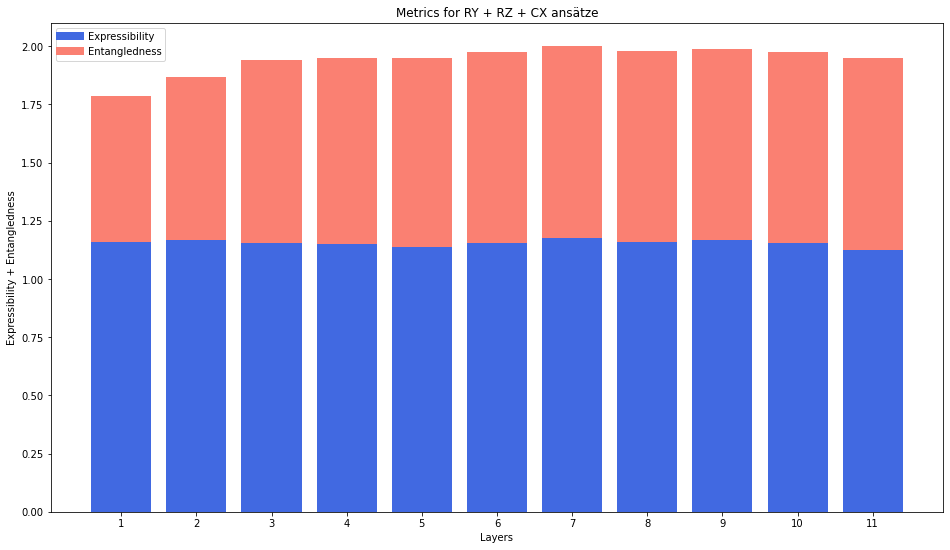

In [261]:
circuits = []

for i in range(1, 12):
    circuits.append(two_local(num_qubits, i, ['ry', 'rz'], 'cx', 'linear'))
    
ry_rz_cx_metrics = compute_metrics(circuits, 1000)
zero_metrics = compute_metrics([QuantumCircuit(num_qubits)], 1000)

ry_rz_cx_expressibility = [(1 / i[0]) - (1 / zero_metrics[0][0]) for i in ry_rz_cx_metrics]
ry_rz_cx_entangledness = [i[1] for i in ry_cz_metrics]


indices = range(len(ry_rz_cx_metrics))
labels = [i + 1 for i in indices]
lines = [Line2D([0], [0], color='royalblue', lw=8, label='Expressibility'),
        Line2D([0], [0], color='salmon', lw=8, label='Entangledness')]

plt.figure(figsize=[16, 9])
plt.bar(indices, ry_rz_cx_expressibility, color='royalblue')
plt.bar(indices, ry_rz_cx_entangledness, color='salmon', bottom=ry_rz_cx_expressibility)
plt.ylabel('Expressibility + Entangledness')
plt.xticks(indices, labels)
plt.xlabel('Layers')
plt.legend(handles=lines)
plt.title('Metrics for RY + RZ + CX ans√§tze')

plt.show()

Since expressibility looks like it stays about constant, we can look at just entangledness:

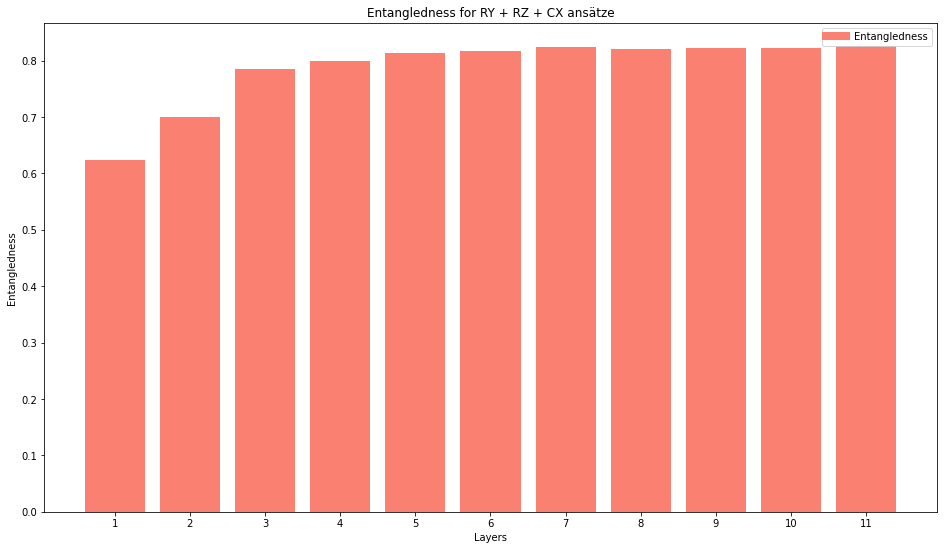

In [260]:
plt.figure(figsize=[16, 9])
plt.bar(indices, ry_rz_cx_entangledness, color='salmon')

plt.ylabel('Entangledness')
plt.xticks(indices, labels)
plt.xlabel('Layers')
plt.legend(handles=[lines[1]])
plt.title('Entangledness for RY + RZ + CX ans√§tze')

plt.show()

It looks like the entangledness saturates at about 6 layers - we don't see any major changes after that. It does however, increase significantly before that (especially from 1 to 3 layers), which confirms our hypothesis about just one round of $n - 1$ $C_Z$s not being enough fully entangle the qubits in the circuit.

The value at which it saturates - about 0.8 - is pretty good! If we look at the chart with the GHZ state, we see that it has the maximum entangledness score possible - 1. So 0.8 is a great entangledness score - with this circuit we should be able to generate highly entangled states.

Let's zoom in to the top of the chart:

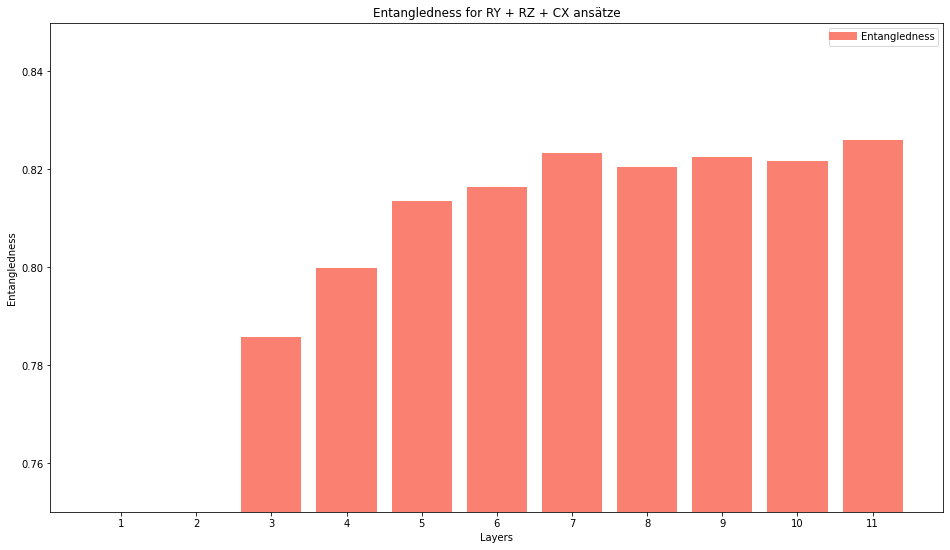

In [284]:
plt.figure(figsize=[16, 9])
plt.bar(indices, ry_rz_cx_entangledness, color='salmon')

plt.ylabel('Entangledness')
plt.xticks(indices, labels)
plt.xlabel('Layers')
plt.legend(handles=[lines[1]])
plt.title('Entangledness for RY + RZ + CX ans√§tze')
plt.ylim(0.75, 0.85)

plt.show()

This behavior - saturating and oscillating about 0.82 - is predicted by the mean $Q$ value for Haar-random states \[[6]\]:

$$E_{Haar} [Q] = \frac{N - 1}{N + 2}$$

where $N$ is the dimension of the Hilbert space we are generating states in. In our case, $N = 16$, so the theoretical value would be:

$$\frac{14}{17} = 0.8236$$

This is a good sign - it means that our circuit is pretty close in behaviour to one that generates Haar-random states.

#### Different entanglement maps

We can also try out different entanglement maps - linear, circular, sca, and full, The first three are similar in that they use a linear number of entanglement gates - the full entanglement map, on the other hand, uses $\frac{n (n - 1)}{2}$ entanglement gates, which can be a mch costlier than the other three options as we increase circuit width.

Since we want to minimize the errors associated with longer circuit depths and an increased number of two qubit gates, a natural question is this: at what point can we swap out a full entanglement block for one that uses a  linear number of two qubit gates, and still get comparable results? Does a point like this even exist?

To investigate this, we can see how the entangledness changes with circuit depth for the different entanglement maps:


[6]: https://arxiv.org/pdf/1905.10876.pdf

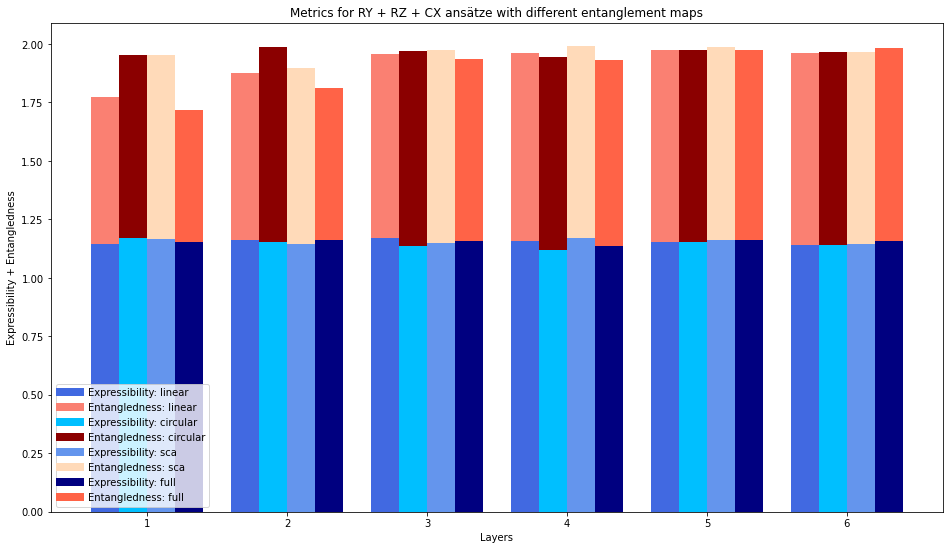

In [267]:
circuits = []
maps = ['linear', 'circular', 'sca', 'full']
maps_metrics = []
width = 0.2
indices = np.array(range(0, 6))
legends = ['Expressibility', 'Entangledness']

colors = [['royalblue', 'deepskyblue', 'cornflowerblue', 'navy'], ['salmon', 'darkred', 'peachpuff', 'tomato']]
lines = [Line2D([0], [0], color=colors[i][j], lw=8, label=legends[i] + ': ' + maps[j]) 
         for j in range(len(maps)) for i in range(2)]

for m in maps:
    circuits.append([two_local(num_qubits, i, ['ry', 'rz'], 'cx', m) for i in range(1, 7)])

zero_metrics = compute_metrics([QuantumCircuit(num_qubits)], 1000)
plt.figure(figsize=[16, 9])

for i, m in enumerate(maps):
    metrics = compute_metrics(circuits[i], 1000)
    expressibility = [(1 / i[0]) - (1 / zero_metrics[0][0]) for i in metrics]
    entangledness = [i[1] for i in metrics]
    maps_metrics.append([expressibility, entangledness])

for i in range(len(maps)):
    plt.bar(indices + (width * i), maps_metrics[i][0], width, color=colors[0][i])
    plt.bar(indices + (width * i), maps_metrics[i][1], width, color=colors[1][i], bottom=maps_metrics[i][0])

plt.ylabel('Expressibility + Entangledness')
plt.xticks(indices + 0.3, indices + 1)
plt.xlabel('Layers')
plt.title('Metrics for RY + RZ + CX ans√§tze with different entanglement maps')

plt.legend(handles=lines, loc='lower left')

plt.show()

Let's look at only the entangledness values:

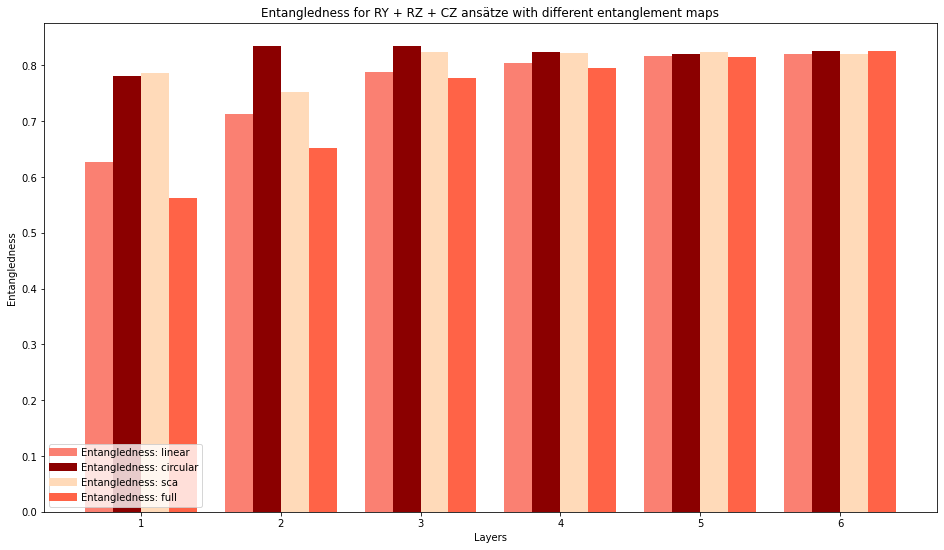

In [268]:
plt.figure(figsize=[16, 9])

for i in range(len(maps)):
    plt.bar(indices + (width * i), maps_metrics[i][1], width, color=colors[1][i])

plt.ylabel('Entangledness')
plt.xticks(indices + 0.3, indices + 1)
plt.xlabel('Layers')
plt.title('Entangledness for RY + RZ + CZ ans√§tze with different entanglement maps')

plt.legend(handles=[lines[2 * i + 1] for i in range(4)], loc='lower left')

plt.show()

We can see that full entanglement performs worse at low circuit depths, but catches up as we increase the number of layers. Circular and sca entanglement maps seem to perform the best at all circuit depths.

Turns out, just by adding one more $C_X$ gate (and going from linear to circular), we can boost our entangledness score by a significant amount - good news for us, sinice we want to squeeze out as much entangledness from every entanglement gate as we can.

Thie results above are interesting because we know that the circular and sca entanglement maps use a linear number of $C_X$ gates, while the full entanglement blocks use a number of two qubit gates in the order of $n^2$ - so we should use a circular or and sca entanglment map, so that we get a high entangledness, as well as the best possible bang for our two qubit gates.

Like we saw in the previous graphs, the expressibility does not change with circuit depth.

Now that we've explored the different properties of some common ans√§tze, let's get our hands dirty and actually put them to use by approximating general n-qubit states.

## Approximating general n qubit states

We first need to construct an objective function - we can use MSE again, but this might make our gradients extremely small, especially while trying to approximate larger states, since we would be dividing the squared loss by the dimension of the statevector ($2^n$). So we can use MSE, but without the division - so just squared error:

In [65]:
def compute_n_qubit_state_loss(qc, params, target_state, values_list):
    """
    Compute n qubit state loss: compute the squared distance between the target and learned states. 
    """
    qc = qc.assign_parameters(params)
    statevector = Statevector.from_instruction(qc).data
    diff = (statevector - target_state) ** 2
    se = sum(abs(diff))
    values_list.append(se)

    return se


def learn_n_qubit_state(target_state, init_params, optimizer, objective_function, qc):
    """
    Learn n qubit state: optimize the circuit parameters to minimize the objective function given.
    """
    values_list = []
    result = optimizer.optimize(len(init_params), 
                                lambda x: objective_function(qc, x, target_state, values_list),
                                initial_point=init_params)
    
    result = list(result)
    result.append(values_list)

    return result

Awesome! Now let's run the circuit we selected for a couple of different target states and see how it performs:

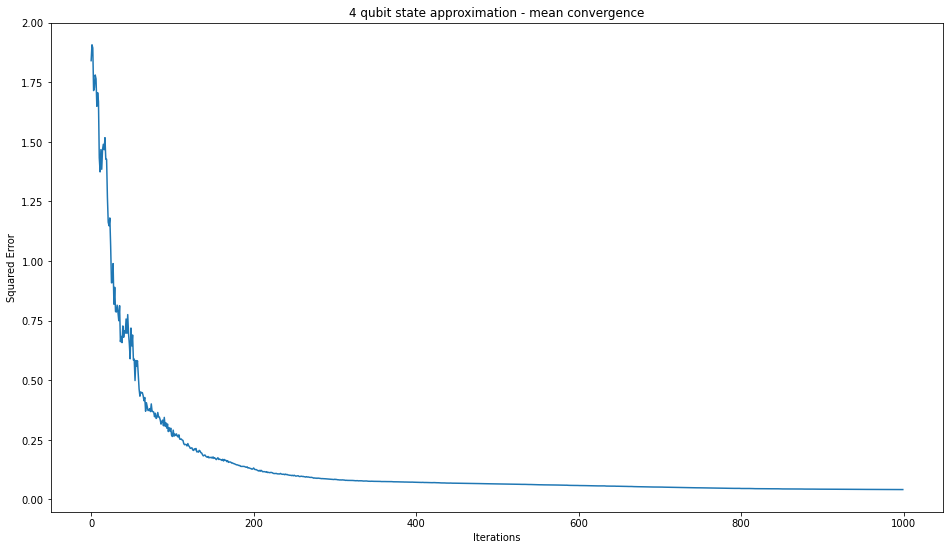

In [66]:
num_trials = 5
num_qubits = 4
target_states = [random_statevector(2 ** num_qubits).data for i in range(num_trials)]
results = []
circ = two_local(num_qubits, 2, ['ry', 'rz'], 'cx', 'circular')

for i in range(num_trials):
    results.append(learn_n_qubit_state(target_states[i], 2 * np.pi * np.random.rand(circ.num_parameters), 
                                       COBYLA(maxiter=1000), compute_n_qubit_state_loss, circ))

    
length = max([len(i[3]) for i in results])

for i in range(num_trials):
    results[i][3] += [results[i][3][-1] for j in range(len(results[i][3]), length)]  

convergence = np.mean(np.concatenate([i[3] for i in results]).reshape(num_trials, length).T, 1)

plt.figure(figsize=[16, 9])
plt.ylabel('Squared Error')
plt.xlabel('Iterations')
plt.title('4 qubit state approximation - mean convergence')
plt.plot(convergence)
plt.show()

Looks pretty good - our circuit gets close to the target state. Let's see how costly this circuit is, and precisely how well it performed:

In [40]:
print('Parameters: {} | Gate Count: {} | Depth: {} | Nonlocal Ops: {}'.format(circ.num_parameters, circ.size(), circ.depth(), 
                                                                             circ.num_nonlocal_gates()))

Parameters: 24 | Gate Count: 32 | Depth: 14 | Nonlocal Ops: 8


In [48]:
for i in range(num_trials):
    print('Trial {} | Squared Error Acheived: {} | Iterations: {}\n'.format(i, results[i][1], results[1][2]))

Trial 0 | Squared Error Acheived: 0.04795537253474506 | Iterations: 1000

Trial 1 | Squared Error Acheived: 0.08627227938229355 | Iterations: 1000

Trial 2 | Squared Error Acheived: 0.03426992019974977 | Iterations: 1000

Trial 3 | Squared Error Acheived: 0.03491822183379078 | Iterations: 1000

Trial 4 | Squared Error Acheived: 0.08460522392283829 | Iterations: 1000



Great - now we know that we can learn 4 qubit states with just 8 $C_X$ gates, i.e. with just a 2 layer ansatz, but what about larger states?

Let's find out.

#### Different state sizes

Here we try to answer this question - how large can a state can we approximate well using just a 2 layer ansatz?

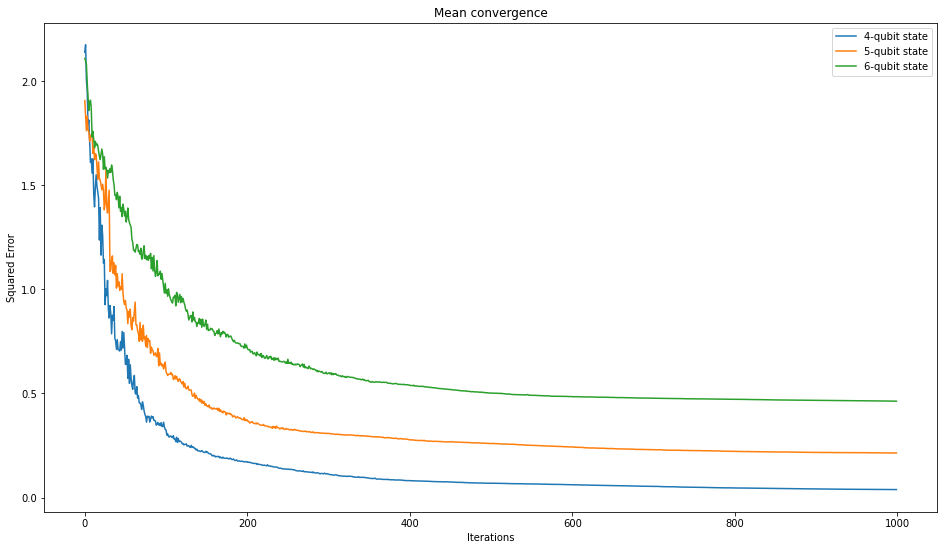

In [67]:
num_trials = 5
sizes = range(4, 7)
target_states = [[random_statevector(2 ** n).data for i in range(num_trials)] for n in sizes]
results = []


for i, size in enumerate(sizes):
    size_results = []
    circ = two_local(size, 2, ['ry', 'rz'], 'cx', 'circular')
    for j in range(num_trials):
        size_results.append(learn_n_qubit_state(target_states[i][j], 2 * np.pi * np.random.rand(circ.num_parameters), 
                                                COBYLA(maxiter=1000), compute_n_qubit_state_loss, circ))
        
    results.append(size_results)
    
mean_convergences = []
for i in range(len(results)):
    length = max([len(j[3]) for j in results[i]])

    for j in range(num_trials):
        results[i][j][3] += [results[i][j][3][-1] for j in range(len(results[i][j][3]), length)]  

    convergence = np.mean(np.concatenate([j[3] for j in results[i]]).reshape(num_trials, length).T, 1)
    mean_convergences.append(convergence)

    
plt.figure(figsize=[16, 9])    
plt.ylabel('Squared Error')
plt.xlabel('Iterations')
plt.title('Mean convergence')

for i in mean_convergences:
    plt.plot(i)
    
plt.legend(['4-qubit state', '5-qubit state', '6-qubit state'])
plt.show()

Looks like our circuit isn't too great at learning states bigger than four qubits - it probably needs an upgrade by adding a few more layers.

Now we know the answer to our question - it's only good enough to learn states of up to four qubits. Why is this?

With more entangledness comes the ability to represent more complex correlations between qubits; the extra rotation gates help with this as well. Shallower circuits are not capable of capturing this complex relationships, hence their relatively lower representation capacities.

#### Different circuit depths

Let's try to find the minimum number of layers we need to represent a 6-qubit state accurately:

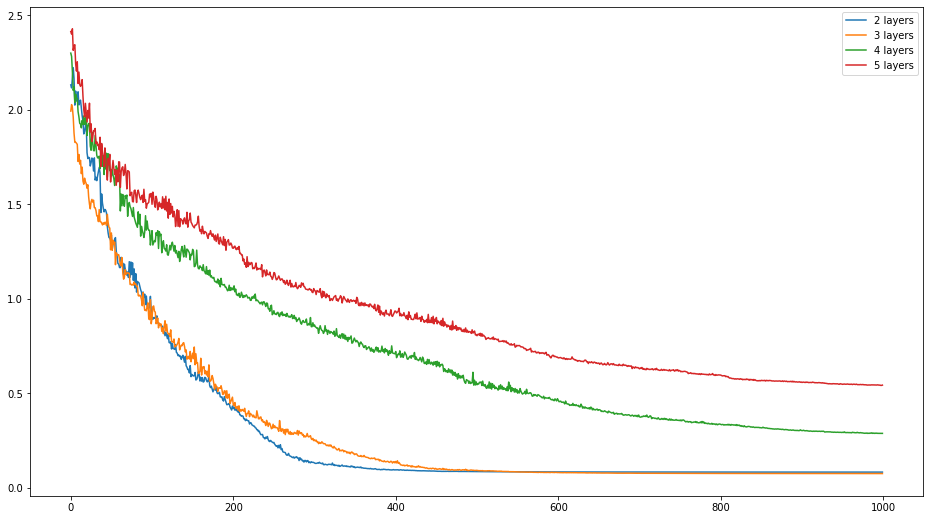

In [70]:
num_trials = 5
num_qubits = 6
depths = range(2, 6)
target_states = [random_statevector(2 ** num_qubits).data for i in range(num_trials)]
results = []


for i, depth in enumerate(depths):
    depth_results = []
    circ = two_local(num_qubits, depth, ['ry', 'rz'], 'cx', 'circular')
    for j in range(num_trials):
        depth_results.append(learn_n_qubit_state(target_states[i][j], 2 * np.pi * np.random.rand(circ.num_parameters), 
                                                COBYLA(maxiter=1000), compute_n_qubit_state_loss, circ))
        
    results.append(depth_results)
    
mean_convergences = []
for i in range(len(results)):
    length = max([len(j[3]) for j in results[i]])

    for j in range(num_trials):
        results[i][j][3] += [results[i][j][3][-1] for j in range(len(results[i][j][3]), length)]  

    convergence = np.mean(np.concatenate([j[3] for j in results[i]]).reshape(num_trials, length).T, 1)
    mean_convergences.append(convergence)

    
plt.figure(figsize=[16, 9])    
    
for i in mean_convergences:
    plt.plot(i)

plt.legend(['2 layers', '3 layers', '4 layers', '5 layers'])
plt.show()

Suprisingly, this time a 2 layer circuit does the trick, beating out all the other circuits we tried - it converges the fastest as well (this is probably due to it having the least number of parameters, which can act as a rough guide as to how hard a circuit will be to optimize).

For the same reason, the four and five layer circuits do not converge - indeed, even towards the right edge of the graph there still remains a significant negative gradient in the loss for these two circuits, versus the loss for the two and three layers circuits, which flattened out after around 300 and 500 iterations, respectively.

### Possible further exploration

A more accurate title for this section would be: work I planned to do but did not get the time to complete; here we look briefly at the things I planned to implement in this work but could not.

#### Other expressibility measures

Apart from mentioning the expressibiliy measure used in this work, \[[6]\] introduces a more holistic measure based on computing the KL divergence between the distribution of fidelities obtained by randomly sampling from the circuit parameter space, and that of the fidelities for Harr-random states, which is given by:

$$P_{Haar}(F) = (N - 1)(1 - F)^{N - 2}$$

where $N$ is the dimension of the Hilbert space, and $F$, the fidelity, can take on values in $[0, 1]$.

This measure is far more accurate than the one used in this work - it is appropriately senstive to increasing circuit depth as well.


#### Barren plateaus, entanglement and trainability

The existence of barren plateaus \[[8]\] in the loss landscapes of variational circuits is now well known. \[[9]\] explored the link between the likelihood of a circuit experiencing a barren plateau and the eigenvalue spectrum of the Fisher information matrix for the variational circuit.

The paper also shows the differences in the eigenvalue spectrums of different quantum circuits (in their case, different data encoding schemes) - by extending this to different ans√§tze, we can look for the common characteristics, in terms of entanglement, circuit depth, and more, of layouts that are less or more likely to experience a barren plateau.

### Conclusions

In this work, I have demonstrated a solution to screening task 1, i.e. n-qubit product state approximation using universal 1-qubit circuits, and have extended the task by looking at universal $n$-qubit circuits, the properties of common ans√§tze, and approximated $n$-qubit states using these.


[6]: https://arxiv.org/pdf/1905.10876.pdf
[8]: https://arxiv.org/abs/1803.11173
[9]: https://arxiv.org/abs/2011.00027

## References

\[1\]  Abhijith J. et al. Quantum Algorithm Implementations for Beginners, 2018. [arXiv:1804.03719 [cs.ET]](https://arxiv.org/abs/1804.03719)

\[2\] Martin Plesch, ƒåaslav Brukner. Quantum-state preparation with universal gate decompositions, 2010. [arXiv:1003.5760 [quant-ph]](https://arxiv.org/abs/1003.5760)

\[3\] Mikko Mottonen, Juha J. Vartiainen, Ville Bergholm, Martti M. Salomaa. Transformation of quantum states using uniformly controlled rotations, 2004. [arXiv:quant-ph/0407010](https://arxiv.org/abs/quant-ph/0407010)

\[4\] Edward Farhi, Hartmut Neven. Classification with Quantum Neural Networks on Near Term Processors, 2018. [arXiv:1802.06002 [quant-ph]](https://arxiv.org/abs/1802.06002)

\[5\] Christa Zoufal, Aur√©lien Lucchi, Stefan Woerner. Variational Quantum Boltzmann Machines, 2020. [arXiv:2006.06004 [quant-ph]](https://arxiv.org/abs/2006.06004)

\[6\] Sukin Sim, Peter D. Johnson, Alan Aspuru-Guzik. Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms, 2019. [arXiv:1905.10876 [quant-ph]](https://arxiv.org/abs/1905.10876)

\[7\] Gavin K. Brennen. An observable measure of entanglement for pure states of multi-qubit systems, 2003. [arXiv:quant-ph/0305094](https://arxiv.org/abs/quant-ph/0305094)

\[8\] Jarrod R. McClean, Sergio Boixo, Vadim N. Smelyanskiy, Ryan Babbush, Hartmut Neven. Barren plateaus in quantum neural network training landscapes, 2018. [arXiv:1803.11173 [quant-ph]](https://arxiv.org/abs/1803.11173)

\[9\] Amira Abbas, David Sutter, Christa Zoufal, Aur√©lien Lucchi, Alessio Figalli, Stefan Woerner. The power of quantum neural networks, 2020. [arXiv:2011.00027 [quant-ph]](https://arxiv.org/abs/2011.00027)